In [1]:
import numpy as np
from functools import partial
import ipywidgets as widgets
from IPython.display import display

In [2]:
#pydrake imports
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions
from pydrake.all import PiecewisePolynomial, InverseKinematics, Sphere, Rgba, RigidTransform, RotationMatrix, IrisInConfigurationSpace
import time
import pydrake
from pydrake.all import (SceneGraphCollisionChecker, 
                         StartMeshcat, 
                         RobotDiagramBuilder,
                         ProcessModelDirectives,
                         LoadModelDirectives,
                         MeshcatVisualizer)

In [3]:
from pydrake.all import Role, MeshcatVisualizerParams
def plant_builder(usemeshcat = False):
    if usemeshcat:
        meshcat = StartMeshcat()
    builder = RobotDiagramBuilder()
    plant = builder.plant()
    scene_graph = builder.scene_graph()
    parser = builder.parser()
    #parser.package_map().Add("cvisirisexamples", missing directory)
    if usemeshcat:
        meshcat_params = MeshcatVisualizerParams()
        #meshcat_params.role = #Role.kProximity
        visualizer = MeshcatVisualizer.AddToBuilder(builder.builder(), scene_graph, meshcat,meshcat_params)
    directives_file = "7_dof_directives_newshelf.yaml"#FindResourceOrThrow() 
    directives = LoadModelDirectives(directives_file)
    models = ProcessModelDirectives(directives, plant, parser)
    plant.Finalize()
    diagram = builder.Build()
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    diagram.ForcedPublish(diagram_context)
    return plant, scene_graph, diagram, diagram_context, plant_context, meshcat if usemeshcat else None

plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder(usemeshcat=True)

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)
import pydrake.multibody.rational as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
Ratfk = RationalForwardKinematics(plant)

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [4]:
sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

q = np.zeros(plant.num_positions())
ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)
def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)   

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)

def showres_s(s_vis):
    showres(Ratfk.ComputeQValue(s_vis, np.zeros(7)))

def showres(qvis):
    plant.SetPositions(plant_context, qvis)
    col = col_func_handle(qvis)
    shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    diagram.ForcedPublish(diagram_context)

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) #do you even geometry bro?
q_min = np.array(q_low)*scaler
q_max = np.array(q_high)*scaler
q_diff = q_max-q_min

# def sample_cfree_QPoint(MAXIT=1000):
# 	it = 0
# 	while it<MAXIT:
# 		rand = np.random.rand(5)
# 		q_s = q_min + rand*q_diff
# 		col = False
# 		for _ in range(10):
# 			r  = 0.05*(np.random.rand(5)-0.5)
# 			col |= (col_func_handle(q_s+r) > 0)
# 		if not col:
# 			return q_s #Ratfk.ComputeQValue(q_s, q_star)
# 		it+=1
# 	raise ValueError("no col free point found")

idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q0', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q1', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q2', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q3', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q4', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q5', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q6', max=3.05433, min=-3.05433)

In [5]:
# start = np.array([-2.06706, -0.3944 ,  1.43294,  0.9056 ,  0.53294, -0.8944 ,
#         0.74567])
# end = np.array([ 1.23294, -0.1944 ,  0.     ,  1.6056 ,  1.43294,  1.1056 ,
#         0.24567])

poi =np.array([[-2.06706, -0.3944 ,  1.43294,  0.9056 ,  0.53294, -0.8944 ,
        0.74567],
        [ 1.23294, -0.1944 ,  0.     ,  1.6056 ,  1.43294,  1.1056 ,
        0.24567],
        [ 1.23294, -0.1944 ,  0.     ,  1.1056 ,  1.43294,  1.1056 ,
       -0.15433],
       [ 1.23294, -0.4944 , -0.06706,  2.0056 ,  1.23294,  1.3056 ,
        0.94567],
        [ 1.83294,  0.3056 , -0.06706, -1.3944 ,  1.53294,  1.4056 ,
       -0.05433],
       [ 1.63294,  0.7056 ,  0.23294, -1.6944 ,  1.53294,  1.2056 ,
       -0.65433]])
showres(poi[5])

In [30]:
import pickle
path = 'logs/experiment_7dof_iiwa__1_1500_0.200greedy20230908201834'
with open(path+'/data/it_5.pkl', 'rb') as f:
    data = pickle.load(f)

regions = []
for ga,gb in zip(data['ra'], data['rb']):
    for a,b in zip(ga,gb):
        regions.append(HPolyhedron(a,b))
regions = regions[:43]

In [7]:
from visibility_utils import point_in_regions
for p in poi:
    print(point_in_regions(p, regions))

False
False
False
False
False
False


In [8]:
from region_generation import SNOPT_IRIS_obstacles
def estimate_coverage(r):
    return 0
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 6
snopt_iris_options.configuration_space_margin = 2e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 15
snopt_iris_options.relative_termination_threshold = 0.02

iris_handle = partial(SNOPT_IRIS_obstacles, 
                        logger = None, 
                        plant = plant, 
                        context = diagram_context,
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1)




In [9]:
# r_poi,_ = iris_handle(poi, [], [])



In [16]:
showres(poi[4,:])

# 213  054
seq = [2,1,3,5,4,0,2] 

In [11]:
#r_poi = [r1[0],r2[0]]
# with open('rpoi_2shelf.pkl', 'wb') as f:
#     ra = [r.A() for r in r_poi]
#     rb = [r.b() for r in r_poi]
#     pickle.dump([ra, rb], f)

In [31]:
import pickle
with open('rpoi_2shelf.pkl', 'rb') as f:
    rpoilist = pickle.load(f)

r_poi = []
for ra, rb in zip(rpoilist[0], rpoilist[1]):
    r_poi.append(HPolyhedron(ra,rb))
#     ra = [r.A() for r in r_poi]
#     rb = [r.b() for r in r_poi]
#     pickle.dump([ra, rb], f)

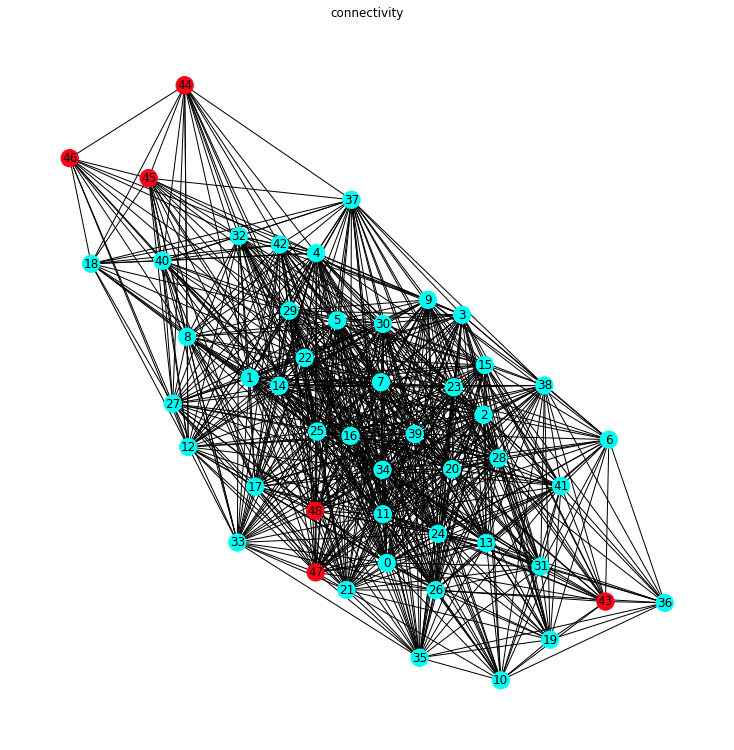

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
from visibility_utils import generate_distinct_colors

regs = regions+r_poi
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)


for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regions, r_poi], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

def conversion_dummy(q):
    return q
import dijkstraspp
#dspp = dijkstraspp.DijkstraSPPsolver(regions + r_poi, conversion_dummy)
# import pickle
dsppname = "7dofnew_dspp.pkl"
with open(dsppname, 'rb') as f:
    dspp = pickle.load( f)
# import pickle
# dsppname = "7dofnew_dspp.pkl"
# with open(dsppname, 'wb') as f:
#     pickle.dump(dspp, f)
def densify_waypoints(waypoints_q):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            plant.SetPositions(plant_context, qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj_s(dense,name = '', color = (1,0,0,1)):
    plot_endeff_traj(np.array([Ratfk.ComputeQValue(w,np.zeros(7)) for w in dense]), name, color)

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [33]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions + r_poi, conversion_dummy)
# import pickle
# dsppname = "7dofnew_dspp_small.pkl"
# with open(dsppname, 'rb') as f:
#     dspp = pickle.load( f)
import pickle
dsppname = "7dofnew_dspp_small.pkl"
with open(dsppname, 'wb') as f:
    pickle.dump(dspp, f)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 49
[DijkstraSPP] Pre-Building adjacency matrix  10 / 49
[DijkstraSPP] Pre-Building adjacency matrix  20 / 49
[DijkstraSPP] Pre-Building adjacency matrix  30 / 49
[DijkstraSPP] Pre-Building adjacency matrix  40 / 49
[DijkstraSPP] Pre-Building d-adjacency matrix  0 / 782


In [34]:
colors = [(1,0,0,1),(1,1,0,1),
(0,1,0,1),
(0,1,1,1),
(0,0,1,1),
(1,0,1,1),
]

meshcat.Delete("/iris/points/traj/")
for idx,i in enumerate(seq[:-1]):
    wp, dist = dspp.solve(poi[i,:], poi[seq[idx+1],:], refine_path = True)
    wpd = densify_waypoints(wp)
    plot_endeff_traj(wpd, str(i), colors[i])


for i in range(10):
    wp, dist = dspp.solve(poi[seq[(i)%len(seq)],:], poi[seq[(i+1)%len(seq)],:], refine_path = True)
    wpd = densify_waypoints(wp)
    for qa in wpd:
        showres(qa)
        if col_func_handle(qa):
            print('col')
            
        time.sleep(0.01)

[DijkstraSPP] optimized distance/ start-distance = 1.24 / 4.70 = 0.26
[DijkstraSPP] optimized distance/ start-distance = 1.35 / 3.64 = 0.37
[DijkstraSPP] optimized distance/ start-distance = 5.62 / 8.48 = 0.66
[DijkstraSPP] optimized distance/ start-distance = 2.55 / 4.42 = 0.58
[DijkstraSPP] optimized distance/ start-distance = 6.12 / 7.46 = 0.82
[DijkstraSPP] optimized distance/ start-distance = 6.56 / 9.36 = 0.70
[DijkstraSPP] optimized distance/ start-distance = 1.24 / 4.70 = 0.26
[DijkstraSPP] optimized distance/ start-distance = 1.35 / 3.64 = 0.37
[DijkstraSPP] optimized distance/ start-distance = 5.62 / 8.48 = 0.66
[DijkstraSPP] optimized distance/ start-distance = 2.55 / 4.42 = 0.58
[DijkstraSPP] optimized distance/ start-distance = 6.12 / 7.46 = 0.82
[DijkstraSPP] optimized distance/ start-distance = 6.56 / 9.36 = 0.70
[DijkstraSPP] optimized distance/ start-distance = 0.00 / 0.00 = nan
[DijkstraSPP] optimized distance/ start-distance = 1.24 / 4.70 = 0.26
[DijkstraSPP] optimiz

In [23]:
meshcat.Delete('Scene/iris/*')

In [30]:
waypoints, dist = dspp.solve(start, end, refine_path=True)
waypoints_dense = densify_waypoints(waypoints)

[DijkstraSPP] optimized distance/ start-distance = 5.95 / 9.49 = 0.63


In [32]:
plot_endeff_traj(waypoints_dense)

In [14]:
def plot_endeff_traj_s(dense,name = '', color = (1,0,0,1)):
    plot_endeff_traj(np.array([Ratfk.ComputeQValue(w,np.zeros(7)) for w in dense]), name, color)

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [205]:
plot_endeff_traj_s(waypoints_s_refined, 'free',(0,1,0,1))
plot_endeff_traj_s(waypoints_s_col_refined, 'col',(1,0,0,1))
#plot_endeff_traj(waypoints_q_backtransf, 'qb',(1,0.5,1,1))

In [211]:

 
for sa in waypoints_s_col_refined:
    #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
    showres_s(sa)
    if col_func_handle(Ratfk.ComputeQValue(sa, np.zeros(7))):
        print('col')
        break
    time.sleep(0.01)

col


In [16]:
#this is how you get the breakpoints and coefficients of the collision free spline

print(f"breakpoints: {coord_splines_s[0].x.shape}")

print(f"coefficients: {coord_splines_s[0].c.shape}")

breakpoints: (30,)
coefficients: (4, 29)


In [ ]:
#this is how you get the breakpoints and coefficients of the spline with collision

print(f"breakpoints: {coord_splines_s_col[0].x.shape}")

print(f"coefficients: {coord_splines_s_col[0].c.shape}")

In [7]:
ur = UrDiagram(num_ur = 1, weld_wrist = True, add_shelf = True,
                 add_gripper = True, use_meshcat=True)
diagram_context = ur.diagram.CreateDefaultContext()
diagram = ur.diagram.ForcedPublish(diagram_context)

plant_context = ur.plant.GetMyMutableContextFromRoot(
        diagram_context)
scene_graph_context = ur.scene_graph.GetMyMutableContextFromRoot(
    diagram_context)
inspector = ur.scene_graph.model_inspector()        
        
# # construct the RationalForwardKinematics of this plant. This object handles the
# # computations for the forward kinematics in the tangent-configuration space
# Ratfk = RationalForwardKinematics(ur.plant)

# # the point about which we will take the stereographic projections
# q_star = np.zeros(ur.plant.num_positions())

# # The object we will use to perform our certification.
# cspace_free_polytope = CspaceFreePolytope(ur.plant, ur.scene_graph,
#                                           SeparatingPlaneOrder.kAffine, q_star)

#from pydrake.all import Box, GetVertices
query = ur.scene_graph.get_query_output_port().Eval(ur.scene_graph.GetMyContextFromRoot(diagram_context))
inspector = query.inspector()
a = inspector.GetCollisionCandidates()
geomids= []
for b, c in a:
    geomids.append(b)
    geomids.append(c)
ids = list(set(inspector.GetAllGeometryIds()))
frame_id_dict = {}
for idx in range(len(ids)):
    #print(idx, plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])))
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='body':
        frame_id_dict['body'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='left_finger':
        frame_id_dict['left_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='right_finger':
        frame_id_dict['right_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_3_link':
        frame_id_dict['ur_wrist_3_link'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_2_link':
        frame_id_dict['ur_wrist_2_link'] = ids[idx]

print(frame_id_dict)
geom_ids = [inspector.GetGeometries(inspector.GetFrameId(frame_id_dict[k]))[0] for k in ['ur_wrist_2_link','ur_wrist_3_link','body', 'left_finger', 'right_finger']]

sh_frames = [6,7, 11,12,13]
sh_geom = [inspector.GetShape(id) for id in geom_ids] 
sh_names = ['ur_wrist_2_link','ur_wrist_3_link', 'box', 'l','r']

def plot_endeff_pose(q2, name = '', color = Rgba(1,1,0.1,0.8)):
    ur.plant.SetPositions(plant_context, q2)
    tfs = [ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(fr))) for fr in sh_frames]
    for n, f, geom in zip(sh_names[2:], tfs[2:], sh_geom[2:]):
        #print(n,f,geom)
        ur.meshcat.SetObject("/iris/shunk/"+name+"/"+n,
                                geom,
                                color)
        ur.meshcat.SetTransform("/iris/shunk/"+name+"/"+n, f)
# for i,p in enumerate(poi):
#     plot_endeff_pose(p, str(i))
def densify_waypoints(waypoints_q):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            ur.plant.SetPositions(plant_context, qa)
            tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        ur.plant.SetPositions(plant_context, qa)
        tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        ur.meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        ur.meshcat.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))



INFO:drake:Meshcat listening for connections at http://localhost:7001


http://localhost:7001
{'ur_wrist_2_link': <GeometryId value=335>, 'ur_wrist_3_link': <GeometryId value=339>, 'body': <GeometryId value=348>, 'left_finger': <GeometryId value=354>, 'right_finger': <GeometryId value=360>}


In [5]:
import pickle
import os

exp_name = "5DOf_ur_20230703210916_16_1000_0.050_0.140"#"5DOf_ur_20230703162006_12_1000_0.050_0.140"
poly_names = os.listdir("logs/"+exp_name+"/regions")
data_chkpts = os.listdir("logs/"+exp_name+"/data")
poly_names.sort()
data_chkpts.sort()
regions = []
for p in poly_names:
    with open("logs/"+exp_name+"/regions/"+p, 'rb') as f:
        d = pickle.load(f)
    regions.append(HPolyhedron(d['ra'], d['rb']))

with open("logs/"+exp_name+"/data/"+data_chkpts[-1], 'rb') as f:
    d2 = pickle.load(f)

seed_points = d2['sp'][-1]

FileNotFoundError: [Errno 2] No such file or directory: 'logs/5DOf_ur_20230703210916_16_1000_0.050_0.140/regions'

In [21]:
showres(seed_points[0, :])

In [7]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions, conversion_dummy)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 24
[DijkstraSPP] Pre-Building adjacency matrix  10 / 24
[DijkstraSPP] Pre-Building adjacency matrix  20 / 24
[DijkstraSPP] Pre-Building d-adjacency matrix  0 / 56


In [8]:
sliders = []
for i in range(ur.plant.num_positions()):
    q_low = ur.plant.GetPositionLowerLimits()[i]
    q_high = ur.plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

q = np.zeros(ur.plant.num_positions())
ik = InverseKinematics(ur.plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)
def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)   

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres_regions(q)

def showres(qvis):
    ur.plant.SetPositions(plant_context, qvis)
    col = col_func_handle(qvis)
    shunk = ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    ur.meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    ur.diagram.ForcedPublish(diagram_context)

from visibility_utils import point_in_regions

def showres_regions(qvis):
    ur.plant.SetPositions(plant_context, qvis)
    is_in_regions = False #point_in_regions(qvis, regions)
    col = col_func_handle(qvis)
    shunk = ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    
    ur.meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                 tf))
    
        
    if is_in_regions:
        ur.meshcat.SetObject(f"/drake/visualizer/inreg",
                                   Sphere(0.2),
                                   col_shunk_free)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/inreg",
                                   Sphere(0.2),
                                   col_shunk_col)
    ur.meshcat.SetTransform(f"/drake/visualizer/inreg",
                                   RigidTransform(RotationMatrix(),
                                                  np.array([0.5,0,0.5])))
    
    ur.diagram.ForcedPublish(diagram_context)

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) #do you even geometry bro?
q_min = np.array(q_low)*scaler
q_max = np.array(q_high)*scaler
q_diff = q_max-q_min

def sample_cfree_QPoint(MAXIT=1000):
	it = 0
	while it<MAXIT:
		rand = np.random.rand(5)
		q_s = q_min + rand*q_diff
		col = False
		for _ in range(10):
			r  = 0.05*(np.random.rand(5)-0.5)
			col |= (col_func_handle(q_s+r) > 0)
		if not col:
			return q_s #Ratfk.ComputeQValue(q_s, q_star)
		it+=1
	raise ValueError("no col free point found")

idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q1', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q2', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q3', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q4', max=2.827433388230814, min=-2.827433388230814)

In [8]:
ur.plant

In [11]:
points = np.array([sample_cfree_QPoint() for i in range(50)])

In [26]:
from pydrake.all import VisibilityGraph
from pydrake.all import SceneGraphCollisionChecker, CollisionCheckerParams


In [28]:
ccp = CollisionCheckerParams()

In [32]:
ccp.

TypeError: 'pydrake.planning.CollisionCheckerParams' object is not callable

In [14]:
VisibilityGraph()

TypeError: VisibilityGraph(): incompatible function arguments. The following argument types are supported:
    1. (checker: pydrake.planning.CollisionChecker, points: numpy.ndarray[numpy.float64[m, n], flags.f_contiguous], parallelize: bool = True) -> scipy.sparse.csc_matrix[bool]

Invoked with: 

In [25]:
SceneGraphCollisionChecker(ur.scene_graph, ur.diagram)

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. pydrake.planning.SceneGraphCollisionChecker(*, model: pydrake.planning.RobotDiagram, **kwargs)

Invoked with: <pydrake.geometry.SceneGraph object at 0x7fb22a4a0c30>, <pydrake.systems.framework.Diagram object at 0x7fb1f2f16cb0>

In [20]:
ur.diagram

In [26]:
q = seed_points[0, :].copy()
print(q)

[ 1.36407114  0.30154314 -0.87237632  1.21614163 -1.68963116]


In [15]:
import time
centers = [r.ChebyshevCenter() for r in regions]
start = centers[0]
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = sample_cfree_QPoint()#centers[np.random.choice(len(centers))]
        plot_endeff_pose(nxt, str(0))
        if nxt[0] != start[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for qa in dense_waypoints:
            #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
            showres(qa)
            if col_func_handle(qa):
                print('col')
                break
            time.sleep(0.002)
        start = nxt
        time.sleep(0.01)
        ur.meshcat.Delete("/iris/points/traj/")
        
    else:
        nxt = centers[np.random.choice(len(centers))]

[DijkstraSPP] optimized distance/ start-distance = 2.99 / 2.99 = 1.00
2.9879363788134192
[DijkstraSPP] optimized distance/ start-distance = 2.84 / 2.84 = 1.00
2.8387958145218644
[DijkstraSPP] optimized distance/ start-distance = 4.74 / 4.74 = 1.00
4.74247521817468
[DijkstraSPP] optimized distance/ start-distance = 4.38 / 9.31 = 0.47
4.377970990412701
[DijkstraSPP] optimized distance/ start-distance = 4.10 / 7.82 = 0.52
4.102441038373757
[DijkstraSPP] optimized distance/ start-distance = 4.31 / 4.31 = 1.00
4.3118886085047246
[DijkstraSPP] optimized distance/ start-distance = 4.37 / 4.37 = 1.00
4.365168225140918
[DijkstraSPP] optimized distance/ start-distance = 3.18 / 3.18 = 1.00
3.1838748432890105
[DijkstraSPP] Points not in set, idxs [0, 3] ,  []
[DijkstraSPP] Points not in regions
-1
[DijkstraSPP] optimized distance/ start-distance = 5.46 / 5.74 = 0.95
5.455250634320856
[DijkstraSPP] optimized distance/ start-distance = 2.74 / 2.74 = 1.00
2.736370264184464
[DijkstraSPP] optimized dis

In [15]:
plot_endeff_pose(centers[25],'0')
plot_endeff_pose(centers[1],'1')




In [25]:
showres(centers[25])

In [10]:
# poi = []
# poi.append(np.array([-0.32743, -0.92743,  0.47257,  0.07257, -0.02743]))
# poi.append(np.array([-1.62743, -1.32743,  2.57257, -1.22743, -0.02743]))
# poi.append(np.array([-1.62743, -2.02743,  1.67257,  0.37257, -0.02743]))
# poi.append(np.array([-1.72743, -1.82743, -2.02743,  0.67257, -0.02743]))
# poi.append(np.array([-1.72743, -1.92743,  1.07257, -2.32743, -0.02743]))
# poi.append(np.array([-1.72743, -1.32743, -0.92743, -1.02743, -0.02743]))
# poi.append(np.array([-1.52743, -2.42743,  0.87257, -1.62743, -0.02743]))
# poi.append(np.array([-2.12743, -0.52743, -1.92743,  2.47257, -1.02743]))

In [35]:
dspp.solve(centers[25], centers[24], refine_path=True)

[DijkstraSPP] optimized distance/ start-distance = 5.73 / 8.28 = 0.69


([array([ 2.7558658 , -0.80848381,  0.38950312,  2.25436946,  1.38754319]),
  array([ 2.75398444, -0.91686666,  0.59956416,  2.18697959,  1.37426211]),
  array([ 2.75019843, -1.10857771,  0.93493879,  1.9522034 ,  1.18961017]),
  array([ 2.7134379 , -1.28521756, -1.92986662,  2.67303004, -2.5139722 ]),
  array([ 2.71147619, -1.29464271, -2.08265237,  2.71147619, -2.71147619])],
 5.728172158276497)

In [12]:
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 8
snopt_iris_options.configuration_space_margin = 1.5e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 15
snopt_iris_options.relative_termination_threshold = 0.02

def SNOPT_IRIS(q_seeds,  region_obstacles, logger, plant, context, snoptiris_options):
	regions = []
	for reg_indx, q_seed in enumerate(q_seeds):
		#q_seed = Ratforwardkin.ComputeQValue(s_seed.reshape(-1,1), np.zeros((7,1)))
		#print('snopt iris call')
		snoptiris_options.configuration_obstacles = []
		if len(region_obstacles):
			snoptiris_options.configuration_obstacles = region_obstacles
		plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
		try:
			#r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), q_star, snoptiris_options)
			r = IrisInConfigurationSpace(plant, plant_context, snoptiris_options)
			r_red = r.ReduceInequalities()
			print(f"[SNOPT IRIS]: Region:{reg_indx} / {len(q_seeds)}")
			#run the certifier
			# cert = cspace_free_polytope.BinarySearch(set(),
			# 								r.A(),
			# 								r.b(), 
			# 								np.array(s_seed),
			# 								binary_search_options)
			if logger is not None: logger.log_region(r_red)
			# r = cert.certified_polytope
			regions.append(r_red)
		except:
			print("error, SNOPT IRIS FAILED")
	return regions

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = ur.plant,
                            context = diagram_context,
                            snoptiris_options = snopt_iris_options,
			    			#binary_search_options = binary_search_options,
                            #Ratforwardkin = Ratfk,
                            )

In [13]:
#setup visibility seeding helpers
from visibility_utils import point_in_regions
from tqdm import tqdm
from scipy.sparse import lil_matrix

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) #do you even geometry bro?
q_min = np.array(q_low)*scaler
q_max = np.array(q_high)*scaler
q_diff = q_max-q_min

alpha = 0.05
eps = 0.25
N = 1000
seed = 1
np.random.seed(seed)

def estimate_coverage(regions, pts = 3000):
	pts_ = [sample_cfree_QPoint() for _ in range(pts)]
	inreg = 0
	for pt in pts_:
		if point_in_regions(pt, regions): inreg+=1
	return inreg/pts

def sample_cfree_QPoint(MAXIT=1000):
	it = 0
	while it<MAXIT:
		rand = np.random.rand(5)
		q_s = q_min + rand*q_diff
		col = False
		for _ in range(10):
			r  = 0.05*(np.random.rand(5)-0.5)
			col |= (col_func_handle(q_s+r) > 0)
		if not col:
			return q_s #Ratfk.ComputeQValue(q_s, q_star)
		it+=1
	raise ValueError("no col free point found")

def sample_cfree_QPoint_in_regions(regions):
	for _ in range(1000):
		pt = sample_cfree_QPoint()
		if point_in_regions(pt, regions): return pt
	return None

def sample_cfree_handle(n, m, regions=None):
		points = np.zeros((n,5))
		if regions is None: regions = []		
		for i in range(n):
			bt_tries = 0
			while bt_tries<m:
				point = sample_cfree_QPoint()
				col = False
				for _ in range(10):
					r  = 0.05*(np.random.rand(5)-0.5)
					col |= point_in_regions(point+r, regions)
				if col:
					bt_tries += 1
					if bt_tries == m:
						return points, True 
				else:
					break
			points[i] = point
		return points, False

# def visSSpace(t1, t2, regions, num_checks, visualizer):
# 	t1flat = t1.reshape(-1)
# 	t2flat = t2.reshape(-1)
# 	if np.linalg.norm(t1-t2) < 1e-6:
# 		return (1-col_func_handle(Ratfk.ComputeQValue(t1flat, q_star)))>0
				
# 	tvec = np.linspace(0,1, num_checks)
# 	for t in tvec:
# 		tinterp = t1flat*t + (1-t)*t2flat
# 		if col_func_handle(Ratfk.ComputeQValue(tinterp, q_star)):
# 			return False
# 		elif point_in_regions(tinterp, regions):
# 			return False
# 	else:
# 		return True

def vis(q1, q2, regions, num_checks):
	q1flat = q1.reshape(-1)
	q2flat = q2.reshape(-1)
	if np.linalg.norm(q1-q2) < 1e-6:
		return (1-col_func_handle(q1))>0
				
	tvec = np.linspace(0,1, num_checks)
	for t in tvec:
		qinterp = q1flat*t + (1-t)*q2flat
		if col_func_handle(qinterp):
			return False
		elif point_in_regions(qinterp, regions):
			return False
	else:
		return True
    
visibility_checker = partial(vis, num_checks = 80)

def vgraph_builder(points, regions):
	n = len(points)
	adj_mat = lil_matrix((n,n))
	for i in tqdm(range(n)):
		point = points[i, :]
		for j in range(len(points[:i])):
			other = points[j]
			result = visibility_checker(point, other, regions)
			#print(result)
			if result:
				adj_mat[i,j] = adj_mat[j,i] = 1
	return adj_mat

In [14]:
from doublegreedyhiddenset import HiddensetDoubleGreedy

dg = HiddensetDoubleGreedy(
    alpha=alpha,
    eps = 0.01,
    max_samples = 100000,
    sample_node_handle=sample_cfree_handle,
    los_handle=visibility_checker,
    verbose=True
)

[21:21:10] [DoubleGreedy] Point insertion attempts M: 298
[21:21:10] [DoubleGreedy] 0.95 probability that unseen region is less than 1.0 "%" of Cfree 


In [15]:
dg.construct_independent_set([])


[21:21:12] [DoubleGreedy] New hidden point placed N =  0 it =  0
[21:21:12] [DoubleGreedy] New hidden point placed N =  1 it =  3
[21:21:13] [DoubleGreedy] New hidden point placed N =  2 it =  81
[21:21:14] [DoubleGreedy] New hidden point placed N =  3 it =  112
[21:21:15] [DoubleGreedy] New hidden point placed N =  4 it =  118
[21:21:19] [DoubleGreedy] Sample set size 607


[array([[-2.5256753 ,  0.41912518, -1.99770284,  0.50501091,  1.12960691]]),
 array([[-2.08007974, -1.65996319, -2.39659582,  0.04479616, -1.34840552]]),
 array([[-2.81117992,  0.39651947, -2.13662351,  2.28737286, -1.83243351]]),
 array([[-0.28439241,  2.71893411,  1.24373364,  0.07368333,  2.35293506]]),
 array([[ 0.17271196, -0.54277826,  2.57226623,  2.25752134, -0.1432099 ]])]

In [16]:
dg.refine_independent_set_greedy([])

[21:21:20] [DoubleGreedy] Hidden point found to split into 2


TypeError: CheckSatisfied(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.solvers.Constraint, x: numpy.ndarray[numpy.float64[m, 1]], tol: float = 1e-06) -> bool
    2. (self: pydrake.solvers.Constraint, x: numpy.ndarray[object[m, 1]], tol: float = 1e-06) -> bool
    3. (self: pydrake.solvers.Constraint, x: numpy.ndarray[object[m, 1]]) -> pydrake.symbolic.Formula

Invoked with: <pydrake.multibody.inverse_kinematics.MinimumDistanceConstraint object at 0x7fafe7e0b530>, array([[-1.14594289,  2.7761749 ,  0.84579928, -0.38859878, -2.17381076]]), 0.01

In [11]:
from visibility_seeding import VisSeeder
from visibility_logging import Logger
import os
LOAD_CHKPT = True

if not LOAD_CHKPT:
    logger = Logger("5DOf_ur", seed, N, alpha, eps, estimate_coverage)
    VS = VisSeeder(N = N,
                alpha = alpha,
                eps = eps,
                max_iterations = 10,
                sample_cfree = sample_cfree_handle,
                build_vgraph = vgraph_builder,
                iris_w_obstacles = SNOPT_IRIS_Handle,
                verbose = True,
                logger = logger
                )
    out = VS.run()
else:
    pass
    #exp_name = "7DOf_shelves_20230617114513_1_1000_0.050_0.200"
    #poly_names = os.listdir("logs/"+exp_name+"/regions")

In [12]:
# r_poi = SNOPT_IRIS_Handle(poi, [], None)
# import pickle
# with open('r_poi_UR5_19.pkl', 'wb') as f:
#     d = {'ra': [r.A() for r in r_poi], 'rb': [r.b() for r in r_poi]}
#     pickle.dump(d, f)

In [12]:
for p in poi:
    print(point_in_regions(p, VS.regions))

NameError: name 'VS' is not defined

In [12]:
# r_poi = SNOPT_IRIS_Handle(poi, [], None) 

[SNOPT IRIS]: Region:0 / 8
[SNOPT IRIS]: Region:1 / 8
[SNOPT IRIS]: Region:2 / 8
[SNOPT IRIS]: Region:3 / 8
[SNOPT IRIS]: Region:4 / 8
[SNOPT IRIS]: Region:5 / 8
[SNOPT IRIS]: Region:6 / 8
[SNOPT IRIS]: Region:7 / 8


In [13]:
import pickle
with open('r_poi_UR5.pkl', 'wb') as f:
    d = {'ra': [r.A() for r in r_poi], 'rb': [r.b() for r in r_poi]}
    pickle.dump(d, f)

In [10]:
import pickle
with open('r_poi_UR5.pkl', 'rb') as f:
   data = pickle.load(f)

r_poi = []
for a,b in zip(data['ra'], data['rb']):
   r_poi.append(HPolyhedron(a,b))

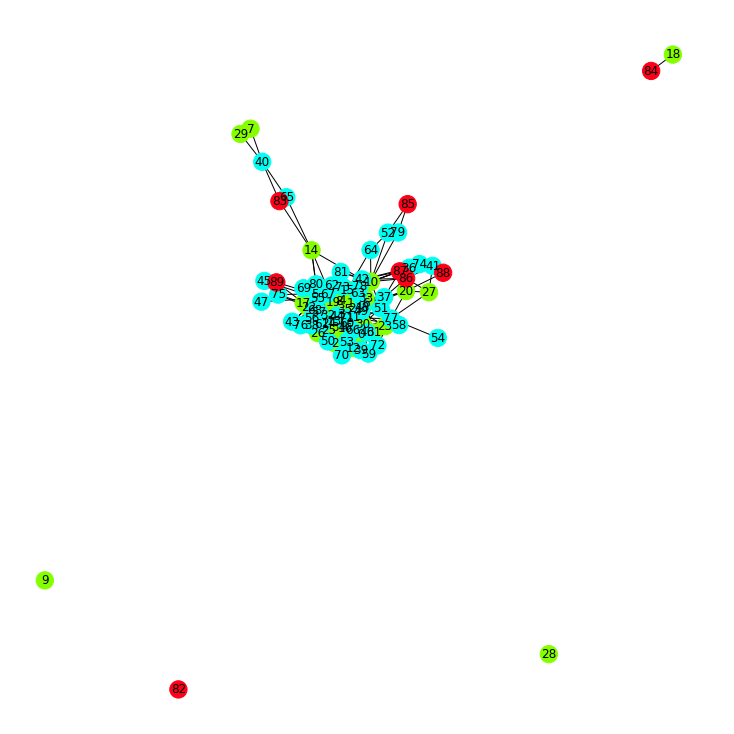

In [13]:
import pickle
import networkx as nx
from visibility_utils import generate_distinct_colors
import matplotlib.pyplot as plt
import os
exp_name = "5DOf_ur_20230628191053_5_1000_0.050_0.250"
poly_names = os.listdir("logs/"+exp_name+"/regions")
data_chkpts = os.listdir("logs/"+exp_name+"/data")
poly_names.sort()
data_chkpts.sort()
regions = []
for p in poly_names:
    with open("logs/"+exp_name+"/regions/"+p, 'rb') as f:
        d = pickle.load(f)
    regions.append(HPolyhedron(d['ra'], d['rb']))

with open("logs/"+exp_name+"/data/"+data_chkpts[-1], 'rb') as f:
    d = pickle.load(f)

r_poi = []
with open("r_poi_UR5_19.pkl", 'rb') as f:
    drpoi = pickle.load(f)
    for A,b in zip(drpoi['ra'], drpoi['rb']):
        r_poi.append(HPolyhedron(A,b))

region_groups_sizes = [len(g) for g in d['rb']]
len_reg = np.sum(region_groups_sizes) 
region_groups_sizes.append(len(regions)-len_reg)
region_groups = []
idx = 0
for s in region_groups_sizes:
    grp = []
    for i in range(s):
        grp.append(regions[i+idx])
    idx+=len(grp)
    region_groups.append(grp)

regions+=r_poi
region_groups.append(r_poi)
connectivity_graph = nx.Graph()
for idx in range(len(regions)):
    connectivity_graph.add_node(idx)
    
for idx1 in range(len(regions)):
    for idx2 in range(idx1 +1, len(regions)):
        r1 = regions[idx1]
        r2 = regions[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(len(region_groups)+1)[1:]
colors = []
for g, h in zip(region_groups, hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.show()

In [ ]:
for p in poi:
    print(point_in_regions(p, regions))

False
True
False
False
False
False
False
False


In [12]:
#from pydrake.all import Box, GetVertices
query = ur.scene_graph.get_query_output_port().Eval(ur.scene_graph.GetMyContextFromRoot(diagram_context))
inspector = query.inspector()
a = inspector.GetCollisionCandidates()
geomids= []
for b, c in a:
    geomids.append(b)
    geomids.append(c)
ids = list(set(inspector.GetAllGeometryIds()))
frame_id_dict = {}
for idx in range(len(ids)):
    #print(idx, plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])))
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='body':
        frame_id_dict['body'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='left_finger':
        frame_id_dict['left_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='right_finger':
        frame_id_dict['right_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_3_link':
        frame_id_dict['ur_wrist_3_link'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_2_link':
        frame_id_dict['ur_wrist_2_link'] = ids[idx]

print(frame_id_dict)
geom_ids = [inspector.GetGeometries(inspector.GetFrameId(frame_id_dict[k]))[0] for k in ['ur_wrist_2_link','ur_wrist_3_link','body', 'left_finger', 'right_finger']]

sh_frames = [6,7, 11,12,13]
sh_geom = [inspector.GetShape(id) for id in geom_ids] 
sh_names = ['ur_wrist_2_link','ur_wrist_3_link', 'box', 'l','r']

def plot_endeff_pose(q2, name = '', color = Rgba(1,1,0.1,0.8)):
    ur.plant.SetPositions(plant_context, q2)
    tfs = [ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(fr))) for fr in sh_frames]
    for n, f, geom in zip(sh_names, tfs, sh_geom):
        #print(n,f,geom)
        ur.meshcat.SetObject("/iris/shunk/"+name+"/"+n,
                                geom,
                                color)
        ur.meshcat.SetTransform("/iris/shunk/"+name+"/"+n, f)
# for i,p in enumerate(poi):
#     plot_endeff_pose(p, str(i))

{'ur_wrist_2_link': <GeometryId value=66>, 'ur_wrist_3_link': <GeometryId value=70>, 'body': <GeometryId value=79>, 'left_finger': <GeometryId value=85>, 'right_finger': <GeometryId value=91>}


In [80]:
for i in ids:
    #print(ur.plant.GetBodyFromFrameId(inspector.GetFrameId(i)).name())
    print(inspector.GetFrameId(i), ur.plant.GetBodyFromFrameId(inspector.GetFrameId(i)).name())

<FrameId value=155> ur_base_link
<FrameId value=155> ur_base_link
<FrameId value=162> ur_shoulder_link
<FrameId value=162> ur_shoulder_link
<FrameId value=169> ur_upper_arm_link
<FrameId value=169> ur_upper_arm_link
<FrameId value=169> ur_upper_arm_link
<FrameId value=169> ur_upper_arm_link
<FrameId value=182> ur_forearm_link
<FrameId value=182> ur_forearm_link
<FrameId value=182> ur_forearm_link
<FrameId value=192> ur_wrist_1_link
<FrameId value=192> ur_wrist_1_link
<FrameId value=199> ur_wrist_2_link
<FrameId value=199> ur_wrist_2_link
<FrameId value=206> ur_wrist_3_link
<FrameId value=213> body
<FrameId value=213> body
<FrameId value=219> left_finger
<FrameId value=219> left_finger
<FrameId value=225> right_finger
<FrameId value=225> right_finger
<FrameId value=9> world
<FrameId value=9> world


[<GeometryId value=231>,
 <GeometryId value=227>,
 <GeometryId value=221>,
 <GeometryId value=217>,
 <GeometryId value=208>,
 <GeometryId value=233>,
 <GeometryId value=204>,
 <GeometryId value=201>,
 <GeometryId value=215>,
 <GeometryId value=157>,
 <GeometryId value=160>,
 <GeometryId value=164>,
 <GeometryId value=177>,
 <GeometryId value=190>,
 <GeometryId value=167>,
 <GeometryId value=180>,
 <GeometryId value=229>,
 <GeometryId value=171>,
 <GeometryId value=184>,
 <GeometryId value=197>,
 <GeometryId value=174>,
 <GeometryId value=187>,
 <GeometryId value=223>,
 <GeometryId value=194>]

In [84]:
plot_endeff_pose(centers[0])

In [70]:
for i in range(15):
    print(ur.plant.get_body(pydrake.multibody.tree.BodyIndex(i)))

<RigidBody_[float] name='world' index=0 model_instance=0>
<RigidBody_[float] name='ur_base_link' index=1 model_instance=2>
<RigidBody_[float] name='ur_shoulder_link' index=2 model_instance=2>
<RigidBody_[float] name='ur_upper_arm_link' index=3 model_instance=2>
<RigidBody_[float] name='ur_forearm_link' index=4 model_instance=2>
<RigidBody_[float] name='ur_wrist_1_link' index=5 model_instance=2>
<RigidBody_[float] name='ur_wrist_2_link' index=6 model_instance=2>
<RigidBody_[float] name='ur_wrist_3_link' index=7 model_instance=2>
<RigidBody_[float] name='ur_ee_link' index=8 model_instance=2>
<RigidBody_[float] name='ur_base' index=9 model_instance=2>
<RigidBody_[float] name='ur_tool0' index=10 model_instance=2>
<RigidBody_[float] name='body' index=11 model_instance=3>
<RigidBody_[float] name='left_finger' index=12 model_instance=3>
<RigidBody_[float] name='right_finger' index=13 model_instance=3>


SystemExit: Failure at bazel-out/k8-opt/bin/multibody/tree/_virtual_includes/multibody_tree_core/drake/multibody/tree/multibody_tree.h:644 in get_body(): condition 'body_index < num_bodies()' failed.

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
def densify_waypoints(waypoints_q):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            ur.plant.SetPositions(plant_context, qa)
            tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        ur.plant.SetPositions(plant_context, qa)
        tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        ur.meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        ur.meshcat.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [12]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions, conversion_dummy)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 35
[DijkstraSPP] Pre-Building adjacency matrix  10 / 35
[DijkstraSPP] Pre-Building adjacency matrix  20 / 35
[DijkstraSPP] Pre-Building adjacency matrix  30 / 35
[DijkstraSPP] Pre-Building d-adjacency matrix  0 / 122


In [18]:
# import pickle 

# with open('logs/5DOf_ur_20230619092515_1_1000_0.050_0.250/5DOf_ur_20230619092515_1_1000_0.050_0.250dspp.pkl', 'rb') as f:
#     a = pickle.load(f)

# dspp = a['dspp']

In [19]:
import time

start = poi[np.random.choice(8)]
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = poi[np.random.choice(8)]
        plot_endeff_pose(nxt, str(0))
        if nxt[0] != start[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for qa in dense_waypoints:
            #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
            showres(qa)
            #if col_func_handle(qa):
            #print(col)
            #break
            time.sleep(0.01)
        start = nxt
        time.sleep(0.01)
        ur.meshcat.Delete("/iris/points/traj/")
        
    else:
        nxt = poi[np.random.choice(8)]

[DijkstraSPP] Points not reachable
-1
[DijkstraSPP] optimized distance/ start-distance = 5.95 / 7.28 = 0.82
5.949949010349506
[DijkstraSPP] optimized distance/ start-distance = 5.95 / 7.28 = 0.82
5.949949010376381
[DijkstraSPP] Points not reachable
-1
[DijkstraSPP] optimized distance/ start-distance = 1.52 / 4.04 = 0.38
1.5187160678449014
[DijkstraSPP] optimized distance/ start-distance = 6.65 / 8.63 = 0.77
6.64700387717575
[DijkstraSPP] Points not reachable
-1
[DijkstraSPP] optimized distance/ start-distance = 11.04 / 13.15 = 0.84
11.04192402466747
[DijkstraSPP] optimized distance/ start-distance = 11.04 / 13.15 = 0.84
11.041924027970772
[DijkstraSPP] optimized distance/ start-distance = 11.04 / 13.15 = 0.84
11.04192402466747
[DijkstraSPP] optimized distance/ start-distance = 7.47 / 8.53 = 0.88
7.468842971405732
[DijkstraSPP] optimized distance/ start-distance = 2.22 / 3.84 = 0.58
2.219805993029459
[DijkstraSPP] Points not reachable
-1
[DijkstraSPP] Points not reachable
-1
[DijkstraSP

KeyboardInterrupt: 

In [21]:
### estimate overlapping region volume
coverage = estimate_coverage(regions, pts = 5000)





In [22]:
def point_in_regions_multi(pt, regions):
    nr_sets =0
    for r in regions:
        if r.PointInSet(pt.reshape(-1,1)):
            nr_sets+=1
    return nr_sets    

npts = 5000
pts_ = [sample_cfree_QPoint() for _ in range(npts)]
inreg = 0
inreg_mult = []
for pt in pts_:
    nr = point_in_regions_multi(pt, regions)
    if nr>0: 
        inreg+=1
        inreg_mult.append(nr)


In [26]:
print('coverage est ',  inreg/npts)
mult = 0
for i in  inreg_mult:
    if i>1:
        mult+=1
print('multicoverage fraction est ', mult/npts)

coverage est  0.817
multicoverage fraction est  0.397


In [24]:
coverage

0.8214

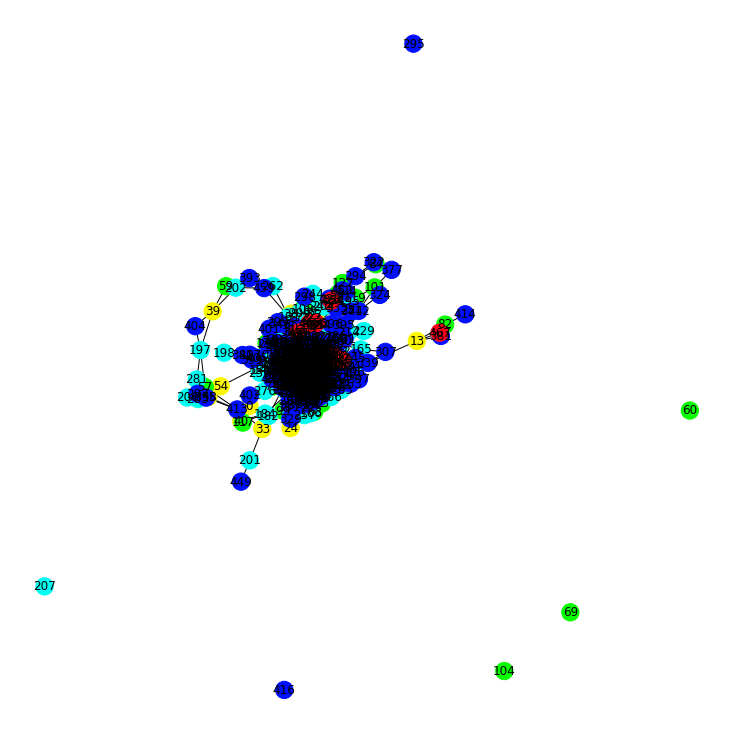

In [30]:
connectivity_graph = nx.Graph()
for idx in range(len(regions)):
    connectivity_graph.add_node(idx)
    
for idx1 in range(len(regions)):
    for idx2 in range(idx1 +1, len(regions)):
        r1 = regions[idx1]
        r2 = regions[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(len(region_groups)+1)[1:]
colors = []
for g, h in zip(region_groups, hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.show()

In [31]:
len(connectivity_graph.edges)

3411

In [32]:
coords = [2,3,4]

q_low_vis = (np.array(ur.plant.GetPositionLowerLimits())[coords]).tolist()
q_high_vis = (np.array(ur.plant.GetPositionUpperLimits())[coords]).tolist()
#coordinates of q0 that are not in coords list are the ones we project onto 
q0 = np.array([0.0,-0.2,0,0,0])



In [29]:
from  pydrake.all import StartMeshcat, DiagramBuilder, AddMultibodyPlantSceneGraph, MeshcatVisualizer

meshcat2 = StartMeshcat()
builder2 = DiagramBuilder()
plant2, scene_graph2 = AddMultibodyPlantSceneGraph(builder2, time_step=0.0)
vis2 = MeshcatVisualizer.AddToBuilder(builder2, scene_graph2, meshcat2)

INFO:drake:Meshcat listening for connections at http://localhost:7003


In [33]:
import old_vis_utils as viz_utils
import mcubes
from pydrake.all import  StartMeshcat, MeshcatVisualizer, DiagramBuilder, \
    AddMultibodyPlantSceneGraph, TriangleSurfaceMesh, Rgba, SurfaceTriangle, Sphere

def transfrom_regions(regions, q_proj, dof_coords):
    small_regs = []
    for r in regions:
        A_new = r.A()[:,dof_coords]
        c_dofs = []
        for i in range(5):
            if i not in dof_coords:
                c_dofs.append(i)
        A_const = r.A()[:, c_dofs]  
        b_new = r.b() - A_const@q_proj[c_dofs]
        #check if region is empty
        rn = HPolyhedron(A_new, b_new)
        if not rn.IsEmpty():
            small_regs.append(rn)
        else:
            print("projected region is empty")
    return small_regs

def plot_regions(regions, ellipses = None,
                     region_suffix = '', colors = None,
                     wireframe = False,
                     opacity = 0.7,
                     fill = True,
                     line_width = 10,
                     darken_factor = .2,
                     el_opacity = 0.3):
        if colors is None:
            colors = viz_utils.n_colors_random(len(regions), rgbs_ret=True)

        for i, region in enumerate(regions):
            c = Rgba(*[col/255 for col in colors[i]],opacity)
            prefix = f"/iris/regions{region_suffix}/{i}"
            name = prefix + "/hpoly"
            if region.ambient_dimension() == 3:
                plot_hpoly3d(name, region,
                                  c, wireframe = wireframe, resolution = 50)

def get_plot_poly_mesh(region, resolution):

        def inpolycheck(q0, q1, q2, A, b):
            q = np.array([q0, q1, q2])
            res = np.min(1.0 * (A @ q - b <= 0))
            # print(res)
            return res

        aabb_max, aabb_min = viz_utils.get_AABB_limits(region)

        col_hand = partial(inpolycheck, A=region.A(), b=region.b())
        vertices, triangles = mcubes.marching_cubes_func(tuple(aabb_min),
                                                         tuple(aabb_max),
                                                         resolution,
                                                         resolution,
                                                         resolution,
                                                         col_hand,
                                                         0.5)
        tri_drake = [SurfaceTriangle(*t) for t in triangles]
        return vertices, tri_drake

def plot_hpoly3d( name, hpoly, color, wireframe = True, resolution = 30):
        verts, triangles = get_plot_poly_mesh(hpoly,
                                                   resolution=resolution)
        meshcat2.SetObject(name, TriangleSurfaceMesh(triangles, verts),
                                color, wireframe=wireframe)

In [35]:
def col_func_handle_vis(qv0,qv1,qv2):
    q_eval = q0.copy()
    q_eval[coords] = np.array([qv0,qv1,qv2])
    return col_func_handle(q_eval)

col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)   


def showres_viz(qv):
    #print(q2)
    
    ur.plant.SetPositions(plant_context, qv) #GetJointByName(f"iiwa_joint_{joint_idx}").set_angle(plant_context, q2[joint_idx-1])
    col = col_func_handle(qv)
    color = Rgba(1, 0.72, 0, 1) if col else Rgba(0.24, 1, 0, 1)
    shunk = ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    #diagram.Publish(context)
    #self.visualize_planes(idx_list)
    #don't change this order
    meshcat2.SetObject(f"/s",
                            Sphere(0.05),
                            color)
    meshcat2.SetTransform(f"/s",
                                RigidTransform(RotationMatrix(),
                                                qv[coords]))
    
    if col:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    ur.meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    ur.diagram.ForcedPublish(diagram_context)

def visualize_collision_constraint(vis2, N = 50, factor = 1, iso_surface = 0.5, wireframe = True):
        """
        :param N: N is density of marchingcubes grid. Runtime scales cubically in N
        :return:
        """

        vertices, triangles = mcubes.marching_cubes_func(tuple(factor*q_low_vis),
                                                         tuple(factor*q_high_vis),
                                                         N, N, N, col_func_handle_vis, iso_surface)
        tri_drake = [SurfaceTriangle(*t) for t in triangles]
        meshcat2.SetObject("/collision_constraint",
                                      TriangleSurfaceMesh(tri_drake, vertices),
                                      Rgba(1, 0, 0, 0.5), wireframe=wireframe)
        return tri_drake, vertices
tri, v = visualize_collision_constraint(vis2, N=40)

In [13]:
r_s = transfrom_regions(regions, q0, coords)
plot_regions(r_s)

projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty


In [27]:

sliders2 = []
for joint_id in coords:
    print(coords)
    joint_idx = joint_id + 1
    sliders2.append(
        widgets.FloatSlider(
        min= np.array(ur.plant.GetPositionLowerLimits())[joint_id],##plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit(), 
        max= np.array(ur.plant.GetPositionUpperLimits())[joint_id],#plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit(), 
        value=0, 
        description=f'ur_joint_{joint_idx}'
        )
    )

q2 = 1.0*q0.copy()

def handle_slider_change_viz(change, idx):
    idch = coords[idx]
    q2[idch] = change['new']
    print(q2[coords[idx]])
    showres_viz(q2)
    
idx = 0
for s in sliders2:
    s.observe(partial(handle_slider_change_viz, idx = idx), names='value')
    idx+=1

for s in sliders2:
    display(s)
    #-0.87237632  1.21614163 -1.68963116

[2, 3, 4]
[2, 3, 4]
[2, 3, 4]


FloatSlider(value=0.0, description='ur_joint_3', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='ur_joint_4', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='ur_joint_5', max=2.827433388230814, min=-2.827433388230814)

-0.12743
-0.22743
-0.12743
-0.02743
0.07257
0.27257
0.47257
0.57257
0.47257
0.37257
0.17257
0.07257
-0.02743
0.07257
-0.02743
-0.12743
-0.22743
-0.42743
-0.52743
-0.72743
-1.02743
-1.12743
-1.22743
-1.32743
-1.22743
-0.92743
0.47257
1.27257
1.17257
-0.22743
-0.42743
-0.22743
-0.12743
-0.22743
-0.42743
-0.62743
-0.82743
-0.92743
-0.82743
-0.72743
-0.82743
-0.92743
-0.82743
-0.92743
-1.02743
-0.92743
-0.82743
0.07257
0.17257
0.27257
0.37257
0.47257
0.57257
0.67257
0.77257
0.87257
0.97257
1.07257
1.17257
1.27257
1.37257
1.27257
1.17257
-0.12743
-0.22743
-0.32743
-0.52743
-0.72743
-0.92743
-1.02743
-1.12743
-1.22743
-1.32743
-1.42743
-1.52743
-1.62743


In [48]:
coords

[2, 3, 4]

In [30]:
for i1, p1 in enumerate(poi[1:]):
    for i2, p2 in enumerate(poi[1:]):
        if i1 !=i2:
            dspp.solve(p1, p2, refine_path=True)

[DijkstraSPP] optimized distance/ start-distance = 4.11 / 4.37 = 0.94
[DijkstraSPP] optimized distance/ start-distance = 7.10 / 8.54 = 0.83
[DijkstraSPP] optimized distance/ start-distance = 4.34 / 7.12 = 0.61
[DijkstraSPP] optimized distance/ start-distance = 6.18 / 7.51 = 0.82
[DijkstraSPP] optimized distance/ start-distance = 5.43 / 7.38 = 0.73
[DijkstraSPP] optimized distance/ start-distance = 6.84 / 8.24 = 0.83
[DijkstraSPP] optimized distance/ start-distance = 4.11 / 4.37 = 0.94
[DijkstraSPP] optimized distance/ start-distance = 4.37 / 5.36 = 0.81
[DijkstraSPP] optimized distance/ start-distance = 5.15 / 6.97 = 0.74
[DijkstraSPP] optimized distance/ start-distance = 4.94 / 7.01 = 0.70
[DijkstraSPP] optimized distance/ start-distance = 4.72 / 6.85 = 0.69
[DijkstraSPP] optimized distance/ start-distance = 5.47 / 5.90 = 0.93
[DijkstraSPP] optimized distance/ start-distance = 7.10 / 8.54 = 0.83
[DijkstraSPP] optimized distance/ start-distance = 4.37 / 5.36 = 0.81
[DijkstraSPP] optimi

In [17]:
with open(exp_name + 'dspp.pkl', 'wb') as f:
    pickle.dump({'dspp': dspp}, f)

In [ ]:
dspppath = "logs/5DOf_ur_20230619092515_1_1000_0.050_0.250dspp.pkl"

In [24]:
from gcs.bezier import BezierGCS

In [25]:
convex_relaxation = True
b_gcs = BezierGCS(regions, order=5, continuity=2)
b_gcs.addTimeCost(1)
b_gcs.addPathLengthCost(1)
b_gcs.setSolver(MosekSolver())

def solve_path(start, end):
    b_gcs.addSourceTarget(start, end)
    bezier_traj = b_gcs.SolvePath(convex_relaxation)[0]

    samples = np.linspace(bezier_traj.start_time(), bezier_traj.end_time(), 200)
    values = np.squeeze([bezier_traj.value(s) for s in samples])
    return values

In [ ]:
import time


start = poi[1+np.random.choice(7)]
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = poi[1+np.random.choice(7)]
        plot_endeff_pose(nxt, str(0))
        if nxt[0] != start[0]:
            break
    #wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    dense_waypoints = solve_path(start, nxt)
    dist =1
    if dist >0:
        #dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for qa in dense_waypoints:
            #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
            showres(qa)
            #if col_func_handle(qa):
            #print(col)
            #break
            time.sleep(0.01)
        start = nxt
        time.sleep(0.01)
        ur.meshcat.Delete("/iris/points/traj/")
        
    else:
        nxt = poi[1+np.random.choice(7)]

: 

: 